
                   KNN MODEL PERFORMANCE                    

Model Accuracy: 0.8474

Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       1.00      0.84      0.91       972
      Stroke       0.23      0.92      0.37        50

    accuracy                           0.85      1022
   macro avg       0.61      0.88      0.64      1022
weighted avg       0.96      0.85      0.89      1022


Evaluation Summary:
ROC AUC Score: 0.9561
Average Precision Score: 0.6635

Performance visualization saved to:
   /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/knn_performance_overview.png


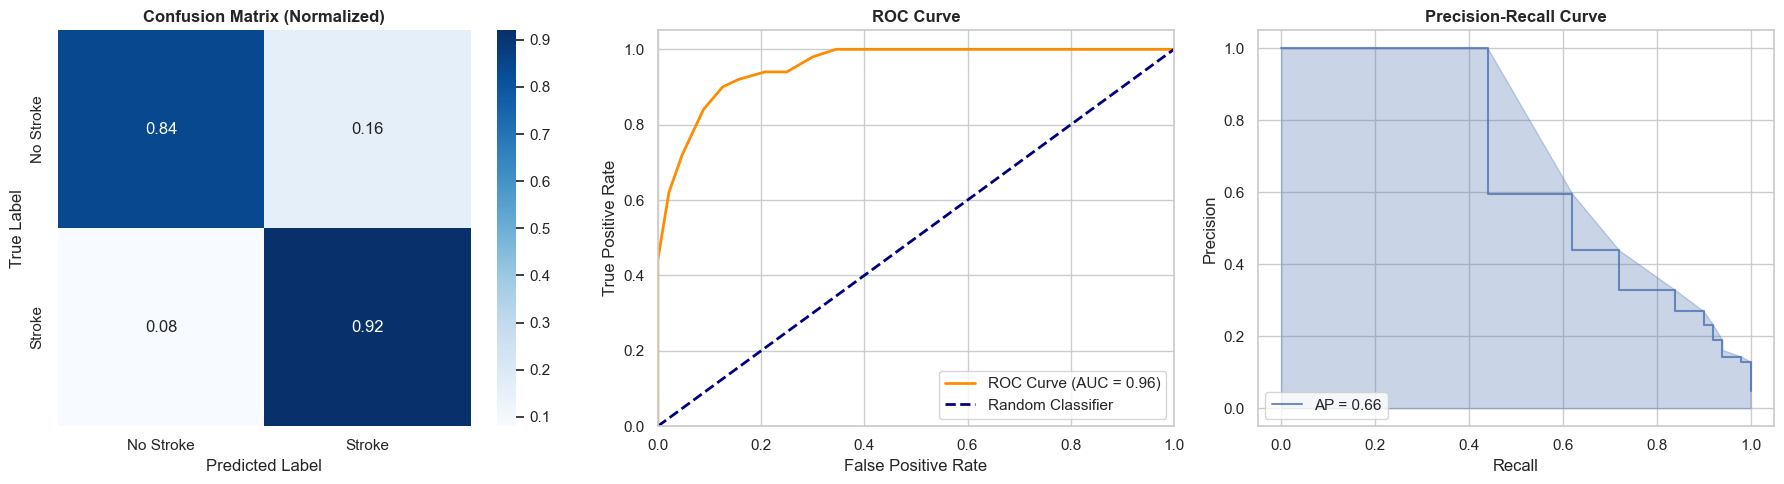

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split
import os

sns.set_theme(style="whitegrid")

# Assigning the path for the dataset and model:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'cleaned_dataset.csv')
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'knn_model.pkl')
REPORT_DIR = os.path.join(BASE_DIR, 'stroke-prediction-project', 'reports')
os.makedirs(REPORT_DIR, exist_ok=True)

def print_header(text):
    print("\n" + "=" * 60)
    print(text.center(60))
    print("=" * 60)

# Loading the dataset:
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=['stroke'])
y = df['stroke']

# Applying the train-test split with 20% of the overall dataset as the test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Loading the trained model:
knn_model = joblib.load(MODEL_PATH)

# Storing the predictions:
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

print_header("KNN MODEL PERFORMANCE")

# Accuracy and Classification Report:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nDetailed Classification Report:")
class_report = classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"])
print(class_report)

# Printing the Evaluation Summary:
print("\nEvaluation Summary:")
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")

plt.figure(figsize=(18, 5))

# 1. Confusion Matrix (Normalized):
plt.subplot(131)
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. ROC Curve:
plt.subplot(132)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve:
plt.subplot(133)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.step(recall, precision, color='b', alpha=0.8, where='post', label=f'AP = {avg_precision:.2f}')
plt.fill_between(recall, precision, alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower left")

plt.tight_layout()
report_path = os.path.join(REPORT_DIR, 'knn_performance_overview.png')
plt.savefig(report_path, dpi=300)

print(f"\nPerformance visualization saved to:\n   {report_path}")
